<a href="https://colab.research.google.com/github/Gabig0l/site_banda/blob/main/examples/python/codigo_classifica%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# bibliotecas
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
# Validar os diretórios
import os
print("Conteúdo de /content:", os.listdir("/content/"))

Conteúdo de /content: ['.config', 'drive', 'sample_data']


In [4]:
# Copiar e extrair o dataset
!cp "/content/drive/MyDrive/Roboflow.zip" /content/
!unzip -q /content/Roboflow.zip -d /content/


In [5]:
# Verifique o conteúdo de /content
import os
print("Conteúdo de /content:", os.listdir("/content/"))


Conteúdo de /content: ['.config', 'Roboflow.zip', 'Roboflow', 'drive', 'sample_data']


In [7]:
import tensorflow as tf

input_size = (299, 299)

train_set = tf.keras.utils.image_dataset_from_directory(
    "/content/Roboflow/train/",
    seed=1337,
    image_size=input_size,
    label_mode='categorical'
)

val_set = tf.keras.utils.image_dataset_from_directory(
    "/content/Roboflow/valid/",
    seed=1337,
    image_size=input_size,
    label_mode='categorical'
)

test_set = tf.keras.utils.image_dataset_from_directory(
    "/content/Roboflow/test/",
    seed=1337,
    image_size=input_size,
    label_mode='categorical'
)


Found 840 files belonging to 5 classes.
Found 80 files belonging to 5 classes.
Found 40 files belonging to 5 classes.


In [8]:
input_size = (299, 299)

# carregar imagens
train_set = tf.keras.utils.image_dataset_from_directory(
    "/content/Roboflow/train",
    seed=1337,
    image_size=input_size,
    label_mode='categorical'
)

val_set = tf.keras.utils.image_dataset_from_directory(
    "/content/Roboflow/valid",
    seed=1337,
    image_size=input_size,
    label_mode='categorical'
)

test_set = tf.keras.utils.image_dataset_from_directory(
    "/content/Roboflow/test",
    seed=1337,
    image_size=input_size,
    label_mode='categorical'
)

# classes
class_names = train_set.class_names

Found 840 files belonging to 5 classes.
Found 80 files belonging to 5 classes.
Found 40 files belonging to 5 classes.


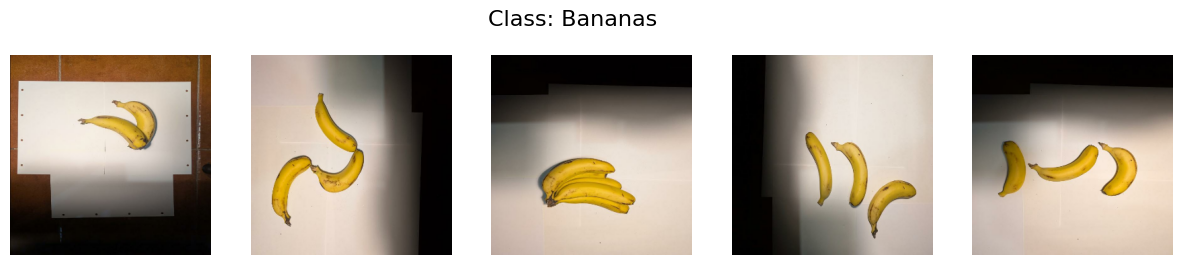

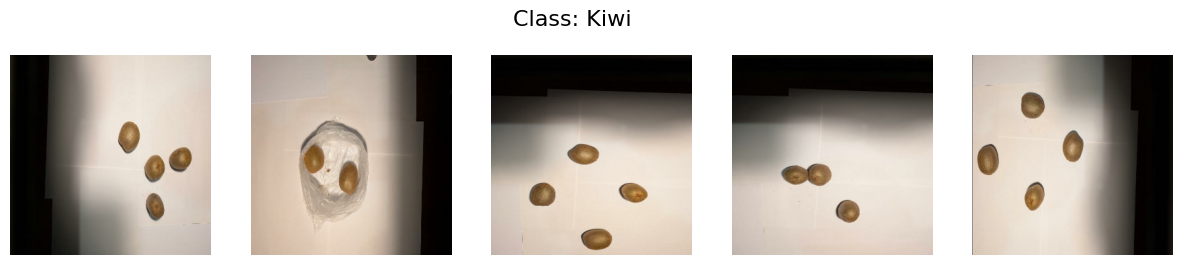

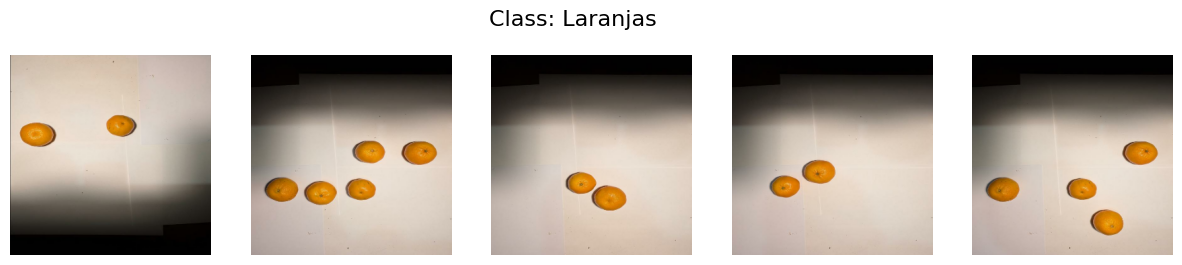

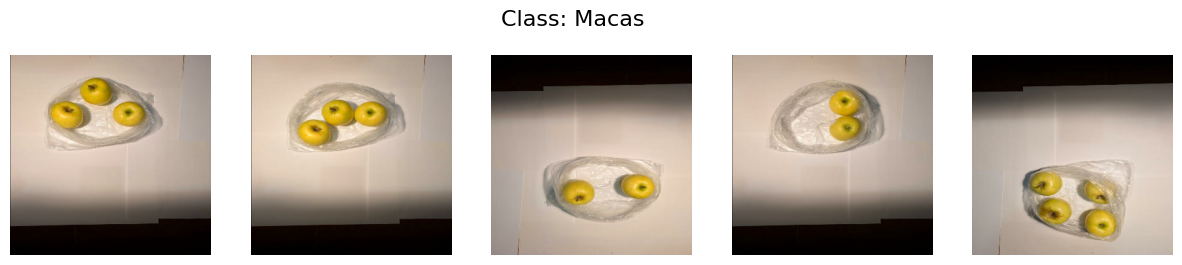

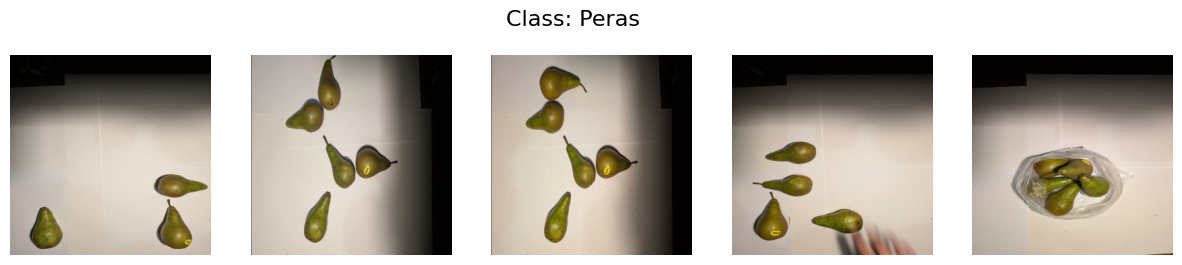

In [9]:
images_by_class = {class_name: [] for class_name in class_names}

for images, labels in train_set.take(-1):
    images_np = images.numpy().astype("uint8")
    labels_np = labels.numpy()

    for img, label in zip(images_np, labels_np):
        class_idx = tf.argmax(label).numpy()
        class_name = class_names[class_idx]

        if len(images_by_class[class_name]) < 5:
            images_by_class[class_name].append(img)

    if all(len(img_list) == 5 for img_list in images_by_class.values()):
        break

for class_name, images in images_by_class.items():
    plt.figure(figsize=(15, 3))
    plt.suptitle(f"Class: {class_name}", fontsize=16)
    for i, img in enumerate(images):
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.show()

In [10]:
# normalização das imagens
train_set = train_set.map(lambda x, y: (x / 255.0, y))
val_set = val_set.map(lambda x, y: (x / 255.0, y))
test_set = test_set.map(lambda x, y: (x / 255.0, y))

In [11]:
# inicializar modelo
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False  # congelar o modelo

# Get the number of classes from your dataset
num_classes = len(class_names)  # Assuming 'class_names' is defined and holds your class labels

# adicionar uma nova layer de saída ao modelo, para classificar as classes corretas
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes, activation='softmax')  # Use num_classes instead of hardcoding 2
])

# compilar modelo
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
# Early stopping callback para parar o treino quando não existe melhoria da validation loss
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,               # pára o treino após 5 épocas
    restore_best_weights=True # reverter os pesos do treino para os melhores obtidos
)

# Reduce learning rate callback para atualizar o learning rate quando não existe melhoria da validation loss
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,               # reduzir learning rate por um fator de 0.1
    patience=3,               # atualiza após 3 épocas
    min_lr=1e-10              # learning rate mínimo
)

model_checkpoint = ModelCheckpoint('/content/model_checkpoint.keras', save_best_only=True, monitor='val_loss', mode='min'),

In [13]:
# treinar o modelo
history = model.fit(train_set,
                    batch_size = 32,
                    epochs=100,
                    validation_data=val_set,
                    callbacks=[early_stopping, reduce_lr, model_checkpoint])

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.3767 - loss: 1.6486 - val_accuracy: 0.7625 - val_loss: 1.1536 - learning_rate: 1.0000e-04
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.7123 - loss: 1.1728 - val_accuracy: 0.9625 - val_loss: 0.8273 - learning_rate: 1.0000e-04
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - accuracy: 0.8806 - loss: 0.8635 - val_accuracy: 0.9625 - val_loss: 0.5993 - learning_rate: 1.0000e-04
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.9185 - loss: 0.6382 - val_accuracy: 0.9875 - val_loss: 0.4656 - learning_rate: 1.0000e-04
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.9356 - loss: 0.5151 - val_accuracy: 0.9875 - val_loss: 0.3653 - learning_rate: 1.0000e-04
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.9407 - loss: 0.4334 - val_accuracy: 0.9875 - val_loss: 0.3090 - learning_rate: 1.0000e-04
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accur

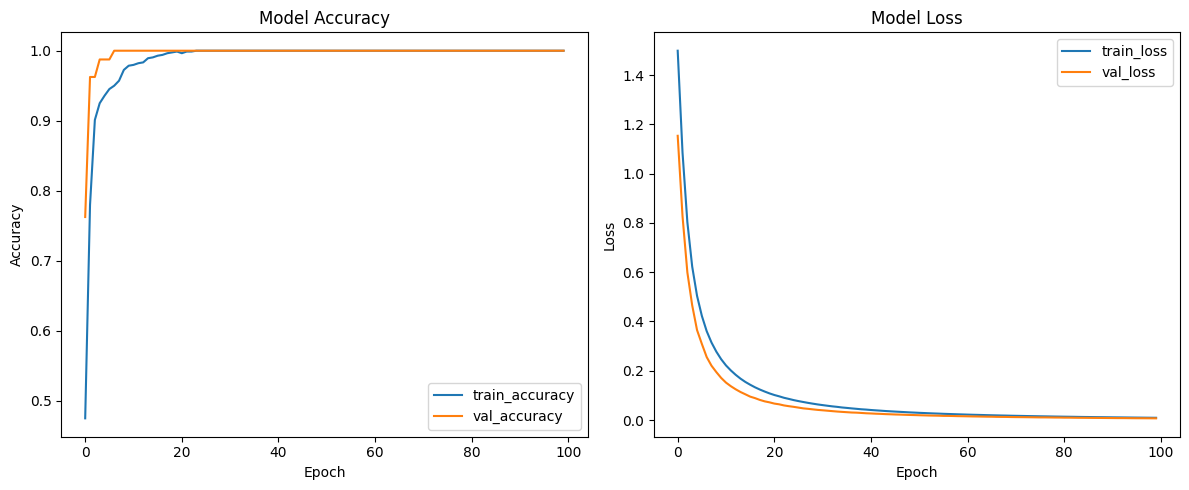

In [14]:
# criar figura
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='train_accuracy')
axes[0].plot(history.history['val_accuracy'], label='val_accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].set_title('Model Accuracy')

# Loss plot
axes[1].plot(history.history['loss'], label='train_loss')
axes[1].plot(history.history['val_loss'], label='val_loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].set_title('Model Loss')

plt.tight_layout()
plt.show()

In [15]:
# avaliar treino com base nos dados de teste
test_loss, test_accuracy = model.evaluate(test_set)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 4s/step - accuracy: 1.0000 - loss: 0.0351
Test accuracy: 100.00%


In [16]:
def test_confusion_matrix(model, test_set, class_names):

    # labels e previsões
    y_true = []
    y_pred = []

    for images, labels in test_set:
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))  # Previsão da classe


        if labels.shape[-1] > 1:
            y_true.extend(np.argmax(labels, axis=1))
        else:
            y_true.extend(labels.numpy())

    # lista para array
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Generate classification report
    print("\n Relatório de Classificação:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # matriz de confusão
    cm = confusion_matrix(y_true, y_pred)

    # matrix de confusão
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("Matriz de Confusão")
    plt.show()

In [ ]:
test_confusion_matrix(model, test_set, class_names)

# **Carregar Modelo Treinado**

In [18]:
# utilizando keras é necessário compilar o modelo antes de carregar os pesos
# o modelo tem de ser exatamente o mesmo

# inicializar modelo
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False  # congelar o modelo

# adicionar uma nova layer de saída ao modelo, para classificar as classes corretas
model_load_weights = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(5, activation='softmax')  # 5 classes
])

# compilar modelo
model_load_weights.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_load_weights.build(input_shape=(None, 299, 299, 3))

# carregar pesos
model_load_weights.load_weights("/content/model_checkpoint.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted class: Macas with confidence: 99.36%


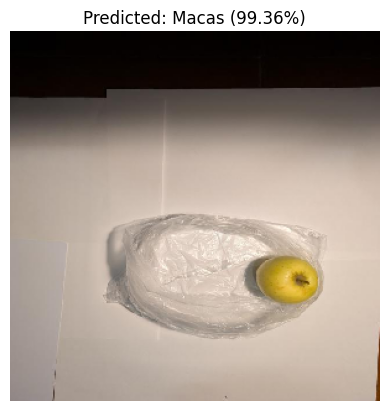

In [25]:
# caminho da imagem
image_path = "/content/Roboflow/test/Maca/PXL_20241126_180418782_jpg.rf.b32769261af0920a1a7653f08c794c1e.jpg"
input_size = (299, 299)  # tamanho da imagem, o mesmo que o da entrada do modelo

# carregar a imagem e alterar as suas dimensões
img = load_img(image_path, target_size=input_size)

# normalizar a imagem
img_array = img_to_array(img) / 255.0

# adicionar batch dimension
img_array = np.expand_dims(img_array, axis=0)

# previsão
predictions = model.predict(img_array)

# classe prevista
predicted_class_idx = np.argmax(predictions, axis=1)[0]
predicted_class = class_names[predicted_class_idx]
confidence = predictions[0][predicted_class_idx]

# resultados
print(f"Predicted class: {predicted_class} with confidence: {confidence * 100:.2f}%")

#mostrar imagem
plt.imshow(img)
plt.title(f"Predicted: {predicted_class} ({confidence * 100:.2f}%)")
plt.axis("off")
plt.show()
